In [10]:
# Standard library
import time
import math
import random
import datetime
from datetime import datetime, timedelta, timezone
import warnings

# Third-party libraries
import numpy as np
import ijson
import pandas as pd
import dtale

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FixedLocator
from matplotlib import colors as mcolors
from matplotlib.patches import Polygon as MplPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Shapely
from shapely.geometry import Polygon, MultiPolygon, LineString, GeometryCollection
from shapely.ops import unary_union, polygonize

# IPython / Widgets (for interactive use)
from ipywidgets import Checkbox, HBox, VBox, HTML
from IPython.display import display
import mplcursors


# For interactive plots (if needed)
%matplotlib widget


In [9]:
def get_left_edge_slope(polygon, debug=False):
    """
    Calculate the slope of the left edge of a rectangle polygon in miles per hour (mph).
    Assumes:
      - x = Unix time (seconds)
      - y = distance in feet
    """
    coords = list(polygon.exterior.coords)

    if coords[0] == coords[-1]:
        coords = coords[:-1]

    if len(coords) != 4:
        raise ValueError("Expected a rectangle with 4 corners.")

    left_points = sorted(coords, key=lambda p: p[0])[:2]
    top = min(left_points, key=lambda p: p[1])
    bottom = max(left_points, key=lambda p: p[1])

    dx_seconds = bottom[0] - top[0]
    dy_feet = bottom[1] - top[1]

    # Avoid divide-by-zero or tiny time deltas
    if dx_seconds < 1e-2:
        return float('inf')

    dy_miles = dy_feet / 5280
    dx_hours = dx_seconds / 3600
    slope_mph = dy_miles / dx_hours

    if debug:
        print(f"Top: {top}, Bottom: {bottom}")
        print(f"dx: {dx_seconds:.2f} sec, dy: {dy_feet:.2f} ft, slope: {slope_mph:.2f} mph")

    return slope_mph





def get_time_length_top_edge(polygon):
    """
    Extracts the top edge (lowest y-values) of a rectangular polygon,
    and calculates the time span (x-direction) between those points.

    Returns:
        dict with:
          - start_ts, end_ts, duration_sec
          - start_str, end_str, duration_str
    """
    coords = list(polygon.exterior.coords)

    # Remove closing point if present (shapely auto-closes polygons)
    if coords[0] == coords[-1]:
        coords = coords[:-1]

    if len(coords) != 4:
        raise ValueError(f"Polygon does not have 4 sides: got {len(coords)}")

    # Find the two points with the lowest y values (top edge in plot)
    top_points = sorted(coords, key=lambda p: p[1])[:2]

    # Determine left/right by comparing x
    top_left = min(top_points, key=lambda p: p[0])
    top_right = max(top_points, key=lambda p: p[0])

    start_ts = top_left[0]
    end_ts = top_right[0]
    duration_sec = end_ts - start_ts

    # Format timestamps
    tz = timezone(timedelta(hours=-6))
    start_str = datetime.fromtimestamp(start_ts, tz=tz).strftime("%H:%M:%S")
    end_str = datetime.fromtimestamp(end_ts, tz=tz).strftime("%H:%M:%S")

    # Duration as H:MM:SS
    duration_td = timedelta(seconds=duration_sec)
    hours, remainder = divmod(int(duration_td.total_seconds()), 3600)
    minutes, seconds = divmod(remainder, 60)
    duration_str = f"{hours}:{minutes:02d}:{seconds:02d}"

    return {
        "start_ts": start_ts,
        "end_ts": end_ts,
        "duration_sec": duration_sec,
        "start_str": start_str,
        "end_str": end_str,
        "duration_str": duration_str,
    }





def interactive_plot_congestion(found_trajectory, polygons_by_label):
    """
    Plot congestion trajectories with toggleable polygon overlays per label and a color-indicated toggle bar.
    
    Args:
        found_trajectory: List of trajectory dicts
        polygons_by_label: Dict of {label: Polygon or list of Polygons}
    """
    # 🎨 Define consistent colors for congestion levels
    label_colors = {
        'light_sub_20': "#04ff00",  # green
        'heavy_sub_10': "#ff0000",  # red
    }

    # Setup figure
    plt.rc('font', family='serif', size=14)
    fig, ax = plt.subplots(figsize=(10, 3))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)

    # Build base scatter from all trajectories
    all_timestamps = []
    all_positions = []
    all_speeds = []

    for traj in found_trajectory:
        all_timestamps.extend(traj["timestamp"])
        all_positions.extend(np.array(traj["x_position"]) / 5280)  # convert to miles
        all_speeds.extend(traj["speed_mph"])

    jet = plt.cm.jet
    colors = [jet(x) for x in np.linspace(1, 0.5, 256)]  # from red to green (inverted)
    green_to_red = LinearSegmentedColormap.from_list('GreenToRed', colors, N=256)

    im = ax.scatter(all_timestamps, all_positions, c=all_speeds, cmap=green_to_red, vmin=0, vmax=80, s=0.1)
    plt.colorbar(im, cax=cax).set_label('Speed (mph)', rotation=90, labelpad=20)
    ax.set_xlabel("Time")
    ax.set_ylabel("Mile marker")

    # Format x-axis (timestamp → time string)
    ticks_loc = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(FixedLocator(ticks_loc))
    x_datetime = [datetime.fromtimestamp(ts, tz=timezone(timedelta(hours=-6))) for ts in ticks_loc]
    labels = [d.strftime('%H:%M:%S') for d in x_datetime]
    ax.set_xticklabels(labels, rotation=45)

    ax.invert_yaxis()

    # Hover formatter
    def format_hover_info(x, y):
        try:
            dt = datetime.fromtimestamp(x, tz=timezone(timedelta(hours=-6)))
            return f"Time: {dt.strftime('%H:%M')}, Mile: {y:.2f}"
        except:
            return f"Time: {x:.2f}, Mile: {y:.2f}"
    ax.format_coord = format_hover_info

    # 🔲 Setup polygon overlays and toggles
    polygon_patches = {}
    toggles = []

    for label, polygons in polygons_by_label.items():
        color = label_colors.get(label, f"#{random.randint(0, 0xFFFFFF):06x}")
        rgba = mcolors.to_rgba(color, alpha=1.0)
        patches = []

        if isinstance(polygons, list):
            shapes = polygons
        elif hasattr(polygons, "geoms"):
            shapes = list(polygons.geoms)
        else:
            shapes = [polygons]

        for poly in shapes:
            coords = np.array(poly.exterior.coords)
            coords[:, 1] /= 5280  # feet to miles
            patch = MplPolygon(coords, facecolor=rgba, edgecolor='black', linewidth=0.8)
            ax.add_patch(patch)
            patches.append(patch)

        # Create toggle with color indicator
        checkbox = Checkbox(value=True, indent=False, layout={'width': '15px'})
        label_html = HTML(f"<span style='color:{color}; font-weight:bold;'>{label.replace('_', ' ').title()}</span>")
        toggles.append(HBox([checkbox, label_html], layout={'align_items': 'center', 'gap': '4px'}))
        polygon_patches[label] = (patches, checkbox)

    # 🔁 Toggle callback
    def update_display(change=None):
        for label, (patches, checkbox) in polygon_patches.items():
            for patch in patches:
                patch.set_visible(checkbox.value)
        fig.canvas.draw_idle()

    for label, (_, checkbox) in polygon_patches.items():
        checkbox.observe(update_display, names='value')
    update_display()

    # ➕ Display toggles (no legend)
    display(VBox(toggles))

    plt.tight_layout()
    plt.show()


def union_parallelograms(parallelograms):
    print("🔁 Unioning parallelograms...")
    t0 = time.time()
    merged = unary_union(parallelograms)
    t1 = time.time()
    print(f"✅ Union complete in {t1 - t0:.2f} seconds.")
    return merged

from shapely.geometry import Polygon
import numpy as np

def create_tilted_parallelogram(x, t, speed, length=200, time_span=60):
    """
    Create a parallelogram centered at (x, t), tilted according to speed.
    - x in feet, t in seconds
    - speed in mph
    """
    mph_to_ftps = 1.46667
    slope = speed * mph_to_ftps  # ft/s
    
    half_len = length / 2
    half_time = time_span / 2
    
    # Compute corners with tilt
    corners = [
        (t - half_time, x - slope * half_time - half_len),
        (t - half_time, x - slope * half_time + half_len),
        (t + half_time, x + slope * half_time + half_len),
        (t + half_time, x + slope * half_time - half_len),
    ]
    return Polygon(corners)


from shapely.geometry import Polygon, MultiPolygon, GeometryCollection

def split_by_thin_connections(polygons, buffer_distance=100):
    """
    For each polygon in the input list, apply erosion followed by dilation.
    This removes thin connections, possibly splitting a polygon into multiple parts.
    
    Args:
        polygons (List[Polygon]): List of input polygons
        buffer_distance (float): Buffer distance for erosion and dilation
    
    Returns:
        List[Polygon]: All resulting polygons after split
    """
    results = []

    for i, poly in enumerate(polygons):
        if poly.is_empty or not isinstance(poly, Polygon):
            continue

        # Erode (shrink) to remove narrow connections
        eroded = poly.buffer(-buffer_distance)
        if eroded.is_empty:
            continue

        # Dilate (expand back to original size)
        dilated = eroded.buffer(buffer_distance)

        # Collect individual polygons
        if isinstance(dilated, (MultiPolygon, GeometryCollection)):
            parts = [g for g in dilated.geoms if isinstance(g, Polygon) and not g.is_empty]
            results.extend(parts)
        elif isinstance(dilated, Polygon):
            results.append(dilated)

    return results




def build_all_parallelograms(points, speeds, length=200, time_span=60):
    parallelograms = []
    n_points = len(points)
    print(f"Building parallelograms for {n_points} points...")
    for i, ((x, t), speed) in enumerate(zip(points, speeds)):
        if i % 100000 == 0 and i > 0:
            print(f"  Processed {i} points...")
        poly = create_tilted_parallelogram(x, t, speed, length, time_span)
        """if i < 5:  # print only for first 5 parallelograms
            print(f"Parallelogram {i} corners: {list(poly.exterior.coords)}")"""
        parallelograms.append(poly)
    print(f"Done creating {len(parallelograms)} parallelograms.")
    return parallelograms

def filter_polygons_by_area(polygons, min_area=10000):
    """
    Filter polygons, keeping only those with area >= min_area.
    """
    if hasattr(polygons, "geoms"):
        poly_list = list(polygons.geoms)
    else:
        poly_list = [polygons]

    kept_polygons = [poly for poly in poly_list if poly.area >= min_area]

    print(f"Filtered {len(poly_list)} polygons down to {len(kept_polygons)} by area >= {min_area}")
    return kept_polygons



def find_congestion_segments_dual(
    file_path,
    traj_threshold_seconds=10,
    direction=-1,
    light_thresh=10,
    heavy_thresh=3,
    min_distance_feet=1,
):
    light_segments = []
    heavy_segments = []
    date = None
    got_date = False
    count = 0

    with open(file_path, 'r') as input_file:
        parser = ijson.items(input_file, 'item', use_float=True)

        for record in parser:
            if record["direction"] != direction:
                continue

            duration = record["last_timestamp"] - record["first_timestamp"]
            if duration < traj_threshold_seconds:
                continue

            if not got_date:
                date = datetime.fromtimestamp(record["first_timestamp"]).date()
                got_date = True

            x_pos = np.array(record["x_position"])
            timestamp = np.array(record["timestamp"])

            # Calculate speed (ft/s → mph)
            speed = np.diff(x_pos) / np.diff(timestamp) * direction
            speed = np.append(speed[0], speed)
            speed *= 0.681818

            def extract_segments(threshold):
                segments = []
                mask = (speed > 0) & (speed <= threshold)
                in_segment = False
                segment_start = 0

                for i in range(len(mask)):
                    if mask[i] and not in_segment:
                        segment_start = i
                        in_segment = True
                    elif not mask[i] and in_segment:
                        segment_end = i - 1
                        in_segment = False
                        distance = x_pos[segment_end] - x_pos[segment_start]
                        if distance * direction >= min_distance_feet:
                            segments.append({
                                "x_position": [x_pos[segment_start], x_pos[segment_end]],
                                "timestamp": [timestamp[segment_start], timestamp[segment_end]],
                                "speed_mph": [speed[segment_start], speed[segment_end]],
                            })

                if in_segment:
                    segment_end = len(mask) - 1
                    distance = x_pos[segment_end] - x_pos[segment_start]
                    if distance * direction >= min_distance_feet:
                        segments.append({
                            "x_position": [x_pos[segment_start], x_pos[segment_end]],
                            "timestamp": [timestamp[segment_start], timestamp[segment_end]],
                            "speed_mph": [speed[segment_start], speed[segment_end]],
                        })
                return segments

            light_segments.extend(extract_segments(light_thresh))
            heavy_segments.extend(extract_segments(heavy_thresh))

            count += 1
            if count % 50000 == 0:
                print(f"Processed {count} trajectories...")

    print(f"{file_path}, {date} → Found (light={len(light_segments)}, heavy={len(heavy_segments)}) segments.")
    return light_segments, heavy_segments, date

def simplify_polygons(polygons, tolerance=1000):
    # If MultiPolygon, simplify each geometry
    if hasattr(polygons, "geoms"):
        simplified_geoms = [poly.simplify(tolerance, preserve_topology=True) for poly in polygons.geoms]
        return MultiPolygon(simplified_geoms)
    elif isinstance(polygons, Polygon):
        return polygons.simplify(tolerance, preserve_topology=True)
    else:
        # If it's a list of polygons
        simplified = [poly.simplify(tolerance, preserve_topology=True) for poly in polygons]
        return simplified

def fill_polygon_gaps(polygons, buffer_distance=100):
    """
    Slightly dilate (expand) each polygon and merge with the original to fill small gaps.
    
    Args:
        polygons (List[Polygon]): Input polygons
        buffer_distance (float): Distance to buffer for filling
    
    Returns:
        List[Polygon]: Cleaned, gap-filled polygons
    """
    filled_polygons = []
    
    for poly in polygons:
        if poly.is_empty or not isinstance(poly, Polygon):
            continue
        
        # Expand slightly
        dilated = poly.buffer(buffer_distance)
        
        # Merge with original to preserve finer detail
        merged = poly.union(dilated)

        # Simplify topology (optional)
        if isinstance(merged, (MultiPolygon, GeometryCollection)):
            parts = [g for g in merged.geoms if isinstance(g, Polygon)]
            filled_polygons.extend(parts)
        else:
            filled_polygons.append(merged)
    
    return filled_polygons



def create_congestion_zones(
    trajs,
    length=250,
    time_span=30,
    min_area=500000,
    simplify_tolerance=5000,
    label=None,
    union=True,
    detailed_zone = True,
    rectify = True,
    min_area_hulls=500000,
    buffer_distance=None,
    fill_gaps_distance=None,
):
    """
    From a list of trajectory segments, extract points/speeds,
    and either return raw parallelograms or a unified simplified polygon.

    Returns:
        - If union=True: simplified unioned polygon
        - If union=False: list of raw parallelograms (no filtering/simplifying)
    """
    print(f"\n🔹 Building congestion polygon for: {label or 'Unnamed'}")
    t0 = time.time()

    # Step 1: Extract points and speeds
    all_points = []
    all_speeds = []
    for traj in trajs:
        if "x_position" in traj:
            all_points.extend(zip(traj["x_position"], traj["timestamp"]))
        else:
            all_points.append((traj["x"], traj["t"]))
        all_speeds.extend(traj["speed_mph"])
    t1 = time.time()
    print(f"✅ Extracted {len(all_points)} points in {t1 - t0:.2f}s.")

    # Step 2: Build parallelograms
    print("🔹 Building parallelograms...")
    parallelograms = build_all_parallelograms(all_points, all_speeds, length=length, time_span=time_span)

    if not union:
        print(f"✅ Returning {len(parallelograms)} raw parallelograms (no union/filter/simplify).")
        return parallelograms

    # Step 3: Union, filter, simplify
    print("🔹 Unioning and simplifying polygons...")
    congestion_polygon = union_parallelograms(parallelograms)
    filtered_by_area = filter_polygons_by_area(congestion_polygon, min_area=min_area)

    # ➕ Erosion-Dilation Split
    if buffer_distance is not None:
        print(f"🔻 Applying erosion-dilation (buffer = {buffer_distance})...")
        filtered_by_area = split_by_thin_connections(filtered_by_area, buffer_distance=buffer_distance)
        print(f"✅ Polygons after erosion-dilation split: {len(filtered_by_area)}")

    if fill_gaps_distance is not None:
        print(f"🩹 Filling small gaps with buffer = {fill_gaps_distance}...")
        filtered_by_area = fill_polygon_gaps(filtered_by_area, buffer_distance=fill_gaps_distance)
        print(f"✅ Polygons after filling gaps: {len(filtered_by_area)}")

    if detailed_zone: 
        t2 = time.time()
        simplified = simplify_polygons(filtered_by_area, tolerance=simplify_tolerance)
        print(f"✅ Big Zone Polygon processed in {t2 - t1:.2f}s (Total: {t2 - t0:.2f}s).")
        return simplified

    convexified = [poly.convex_hull for poly in filtered_by_area]


    # Optionally simplify here if needed
    # simplified = simplify_polygons(convexified, tolerance=simplify_tolerance)

    # Merge convex hulls back together
    merged_convex = unary_union(convexified)

    # Normalize to list
    if isinstance(merged_convex, (MultiPolygon, GeometryCollection)):
        merged_list = [g for g in merged_convex.geoms if isinstance(g, Polygon)]
    else:
        merged_list = [merged_convex]

# ✅ Filter by area
    final_polygons = [poly for poly in merged_list if poly.area >= min_area_hulls]
    
    if not rectify:
        return final_polygons
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        final_polygons_rectified = [
            poly.minimum_rotated_rectangle for poly in final_polygons
        ]
    t2 = time.time()
    print(f"✅ Polygon processed in {t2 - t1:.2f}s (Total: {t2 - t0:.2f}s).")
    # ✅ Print number of final rectangles
    print(f"✅ Final polygons (rectified): {len(final_polygons_rectified)}")
    return final_polygons_rectified








In [7]:
first_time = True

In [ ]:
file_paths = [
    "/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/637d8ea678f0cb97981425dd__post3.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/6380728cdd50d54aa5af0cf5__post5.json",
]

file_paths = [
    "/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json",
]

all_rows = []

for path in file_paths:
    
    if first_time:
        trajs_light, trajs_heavy, date = find_congestion_segments_dual(
            path,
            light_thresh=20,
            heavy_thresh=10,
        )
        
    distance_to_cover = 250
    time_to_cover = 3
    min_area = 10000
    min_area_hulls = 50000
    simplify_tolerance = 0
    union_bool = True

    simplified_polygons_light = create_congestion_zones(
        trajs_light,
        length=distance_to_cover,
        time_span=time_to_cover,
        min_area=min_area,
        simplify_tolerance=simplify_tolerance,
        union=union_bool,
        min_area_hulls=min_area_hulls,
        label="light_sub_20"
    )

    simplified_polygons_heavy = create_congestion_zones(
        trajs_heavy,
        length=distance_to_cover,
        time_span=time_to_cover,
        min_area=min_area,
        simplify_tolerance=simplify_tolerance,
        union=union_bool,
        min_area_hulls=min_area_hulls,
        label="heavy_sub_10"
    )

    interactive_plot_congestion(
        trajs_light,
        polygons_by_label={
            "light_sub_20": simplified_polygons_light,
            "heavy_sub_10": simplified_polygons_heavy,
        }
    )

    # Combine time + slope extraction in one pass to prevent mismatch
    time_lengths_light = []
    for rect in simplified_polygons_light:
        t = get_time_length_top_edge(rect)
        t["slope"] = get_left_edge_slope(rect, debug=False)
        time_lengths_light.append(t)

    time_lengths_heavy = []
    for rect in simplified_polygons_heavy:
        t = get_time_length_top_edge(rect)
        t["slope"] = get_left_edge_slope(rect, debug=False)
        time_lengths_heavy.append(t)



    for t in time_lengths_light:
        all_rows.append({
            "file": path.split("/")[-1],
            "date": date,
            "type": "light_sub_20",
            "start": t["start_str"],
            "end": t["end_str"],
            "duration": t["duration_str"],
            "duration_sec": t["duration_sec"],
            "slope": t["slope"], 
        })

    for t in time_lengths_heavy:
        all_rows.append({
            "file": path.split("/")[-1],
            "date": date,
            "type": "heavy_sub_10",
            "start": t["start_str"],
            "end": t["end_str"],
            "duration": t["duration_str"],
            "duration_sec": t["duration_sec"],
            "slope": t["slope"], 
        })

first_time = False

# Show as table
df = pd.DataFrame(all_rows)
cols = ["date", "type", "start", "end", "duration", "duration_sec", "slope", "file"]
df = df[cols]
df = df.sort_values(by=["date", "file", "type", "start", "duration"])

dtale.show(df)



Processed 50000 trajectories...
Processed 100000 trajectories...
Processed 150000 trajectories...
Processed 200000 trajectories...
Processed 250000 trajectories...
/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json, 2022-11-21 → Found (light=188008, heavy=168265) segments.

🔹 Building congestion polygon for: light_sub_20
✅ Extracted 376016 points in 0.07s.
🔹 Building parallelograms...
Building parallelograms for 376016 points...
  Processed 100000 points...
  Processed 200000 points...
  Processed 300000 points...
Done creating 376016 parallelograms.
🔹 Unioning and simplifying polygons...
🔁 Unioning parallelograms...
✅ Union complete in 13.17 seconds.
Filtered 472 polygons down to 6 by area >= 500000
✅ Polygon processed in 17.35s (Total: 17.41s).
✅ Final polygons (rectified): 5

🔹 Building congestion polygon for: heavy_sub_10
✅ Extracted 336530 points in 0.05s.
🔹 Building parallelograms...
Building parallelograms for 336530 points...
  Processed 100000 points

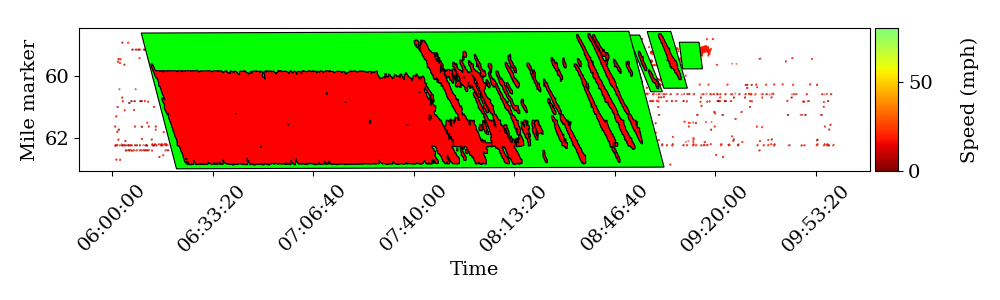

Processed 50000 trajectories...
Processed 100000 trajectories...
Processed 150000 trajectories...
Processed 200000 trajectories...
Processed 250000 trajectories...
/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json, 2022-11-22 → Found (light=109745, heavy=68607) segments.

🔹 Building congestion polygon for: light_sub_20
✅ Extracted 219490 points in 0.04s.
🔹 Building parallelograms...
Building parallelograms for 219490 points...
  Processed 100000 points...
  Processed 200000 points...
Done creating 219490 parallelograms.
🔹 Unioning and simplifying polygons...
🔁 Unioning parallelograms...
✅ Union complete in 7.84 seconds.
Filtered 752 polygons down to 7 by area >= 500000
✅ Polygon processed in 10.10s (Total: 10.15s).
✅ Final polygons (rectified): 3

🔹 Building congestion polygon for: heavy_sub_10
✅ Extracted 137214 points in 0.02s.
🔹 Building parallelograms...
Building parallelograms for 137214 points...
  Processed 100000 points...
Done creating 137214 parall

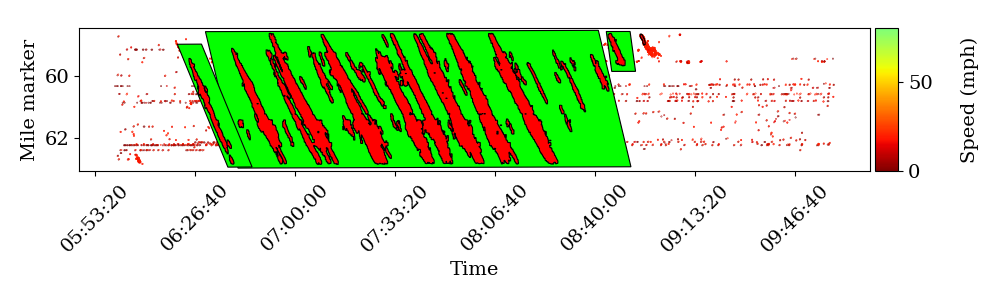

Processed 50000 trajectories...
Processed 100000 trajectories...
Processed 150000 trajectories...
/Users/Ludwig/Documents/GitHub/data_demo/637d8ea678f0cb97981425dd__post3.json, 2022-11-23 → Found (light=27253, heavy=15784) segments.

🔹 Building congestion polygon for: light_sub_20
✅ Extracted 54506 points in 0.01s.
🔹 Building parallelograms...
Building parallelograms for 54506 points...
Done creating 54506 parallelograms.
🔹 Unioning and simplifying polygons...
🔁 Unioning parallelograms...
✅ Union complete in 2.01 seconds.
Filtered 719 polygons down to 3 by area >= 500000
✅ Polygon processed in 2.64s (Total: 2.65s).
✅ Final polygons (rectified): 3

🔹 Building congestion polygon for: heavy_sub_10
✅ Extracted 31568 points in 0.01s.
🔹 Building parallelograms...
Building parallelograms for 31568 points...
Done creating 31568 parallelograms.
🔹 Unioning and simplifying polygons...
🔁 Unioning parallelograms...
✅ Union complete in 1.00 seconds.
Filtered 1380 polygons down to 17 by area >= 50000

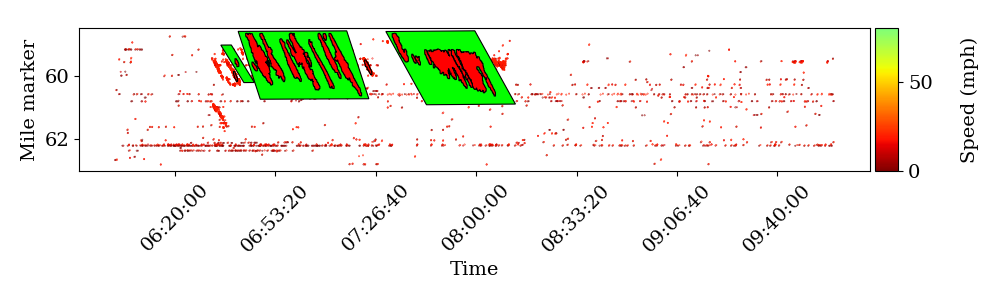

Processed 50000 trajectories...
Processed 100000 trajectories...
Processed 150000 trajectories...
Processed 200000 trajectories...
Processed 250000 trajectories...
Processed 300000 trajectories...
Processed 350000 trajectories...
/Users/Ludwig/Documents/GitHub/data_demo/6380728cdd50d54aa5af0cf5__post5.json, 2022-11-25 → Found (light=1634, heavy=1354) segments.

🔹 Building congestion polygon for: light_sub_20
✅ Extracted 3268 points in 0.00s.
🔹 Building parallelograms...
Building parallelograms for 3268 points...
Done creating 3268 parallelograms.
🔹 Unioning and simplifying polygons...
🔁 Unioning parallelograms...
✅ Union complete in 0.18 seconds.
Filtered 1223 polygons down to 0 by area >= 500000
✅ Polygon processed in 0.22s (Total: 0.22s).
✅ Final polygons (rectified): 0

🔹 Building congestion polygon for: heavy_sub_10
✅ Extracted 2708 points in 0.00s.
🔹 Building parallelograms...
Building parallelograms for 2708 points...
Done creating 2708 parallelograms.
🔹 Unioning and simplifying 

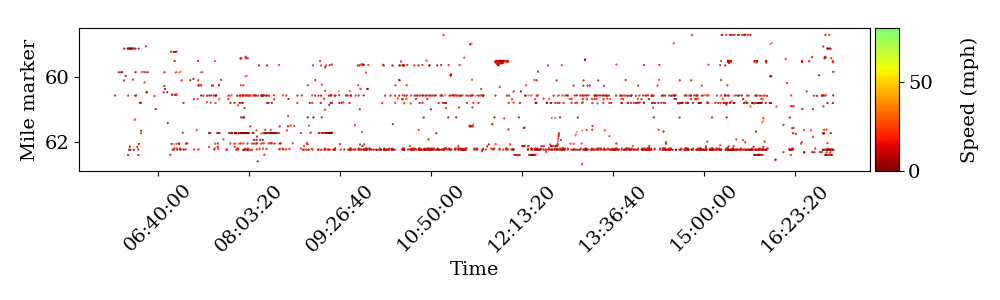

In [11]:
plt.close('all')

file_paths = [
    "/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/637c399add50d54aa5af0cf4__post2.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/637d8ea678f0cb97981425dd__post3.json",
    "/Users/Ludwig/Documents/GitHub/data_demo/6380728cdd50d54aa5af0cf5__post5.json",
]

"""file_paths = [
    "/Users/Ludwig/Documents/GitHub/data_demo/637b023440527bf2daa5932f__post1.json",
]"""

all_rows = []

for path in file_paths:
    
    if first_time:
        trajs_light, trajs_heavy, date = find_congestion_segments_dual(
            path,
            light_thresh=20,
            heavy_thresh=10,
        )
        
    distance_to_cover = 250
    time_to_cover = 3
    min_area = 10000
    min_area_hulls = 50000
    simplify_tolerance = 0
    union_bool = True

    simplified_polygons_light = create_congestion_zones(
        trajs_light,
        length=250,
        time_span=30,
        min_area=500000,
        simplify_tolerance=0,
        union=union_bool,
        detailed_zone=False,
        rectify=True,
        min_area_hulls=min_area_hulls,
        label="light_sub_20"
    )

    simplified_polygons_heavy = create_congestion_zones(
        trajs_heavy,
        length=500,
        time_span=5,
        min_area=50000,
        simplify_tolerance=0,
        union=union_bool,
        detailed_zone=True,
        min_area_hulls=min_area_hulls,
        buffer_distance=5,
        fill_gaps_distance=5,
        label="heavy_sub_10"
    )

    interactive_plot_congestion(
        trajs_light,
        polygons_by_label={
            "light_sub_20": simplified_polygons_light,
            "heavy_sub_10": simplified_polygons_heavy,
        }
    )
    
    # Combine time + slope extraction in one pass to prevent mismatch
    time_lengths_light = []
    for rect in simplified_polygons_light:
        t = get_time_length_top_edge(rect)
        t["slope"] = get_left_edge_slope(rect, debug=False)
        time_lengths_light.append(t)

    """time_lengths_heavy = []
    for rect in simplified_polygons_heavy:
        t = get_time_length_top_edge(rect)
        t["slope"] = get_left_edge_slope(rect, debug=False)
        time_lengths_heavy.append(t)"""



    for t in time_lengths_light:
        all_rows.append({
            "file": path.split("/")[-1],
            "date": date,
            "type": "light_sub_20",
            "start": t["start_str"],
            "end": t["end_str"],
            "duration": t["duration_str"],
            "duration_sec": t["duration_sec"],
            "slope": t["slope"], 
        })

    """for t in time_lengths_heavy:
        all_rows.append({
            "file": path.split("/")[-1],
            "date": date,
            "type": "heavy_sub_10",
            "start": t["start_str"],
            "end": t["end_str"],
            "duration": t["duration_str"],
            "duration_sec": t["duration_sec"],
            "slope": t["slope"], 
        })"""

first_time = False